Loading data...
Columns available in the loaded DataFrame:
['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
Building model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Training...
Epoch 1/30
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0063
Epoch 1: val_loss improved from inf to 0.01200, saving model to models/eth_lstm.best.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0064 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 2/30
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0060
Epoch 2: val_loss improved from 0.01200 to 0.00035, saving model to models/eth_lstm.best.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0064 - val_loss: 3.5263e-04 - learning_rate: 0.0010
Epoch 3/30
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0040
Epoch 3: val_loss did not improve from 0.00035
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0044 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0041
Epoch 4: val_loss did not improve from 0.00035
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0042 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 5/30
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/s

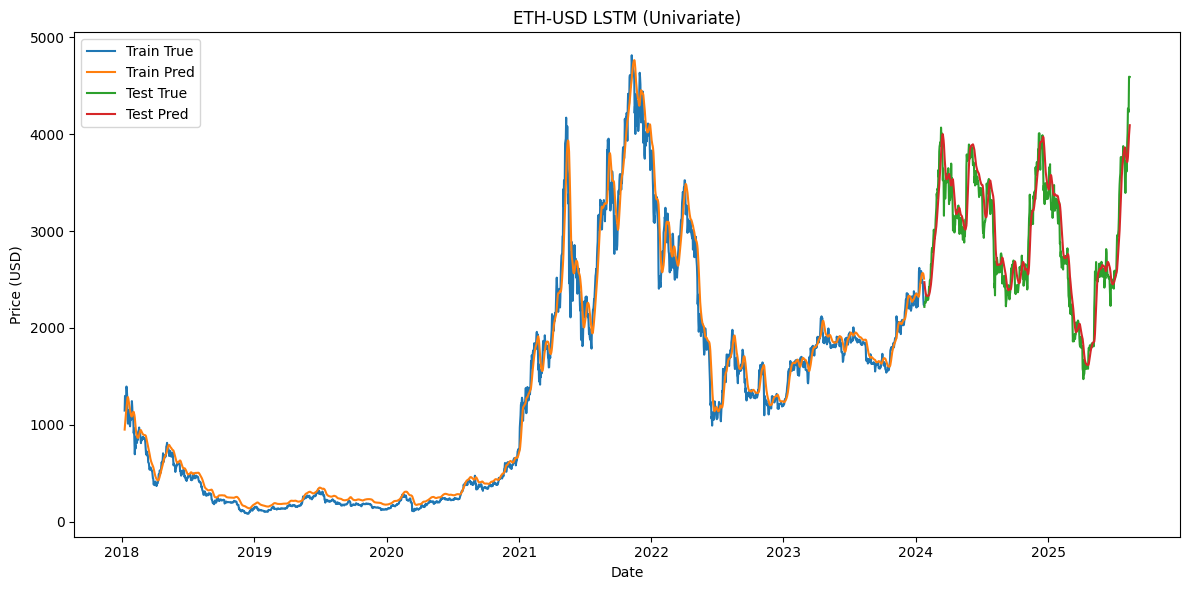


Forecasting next 14 days...


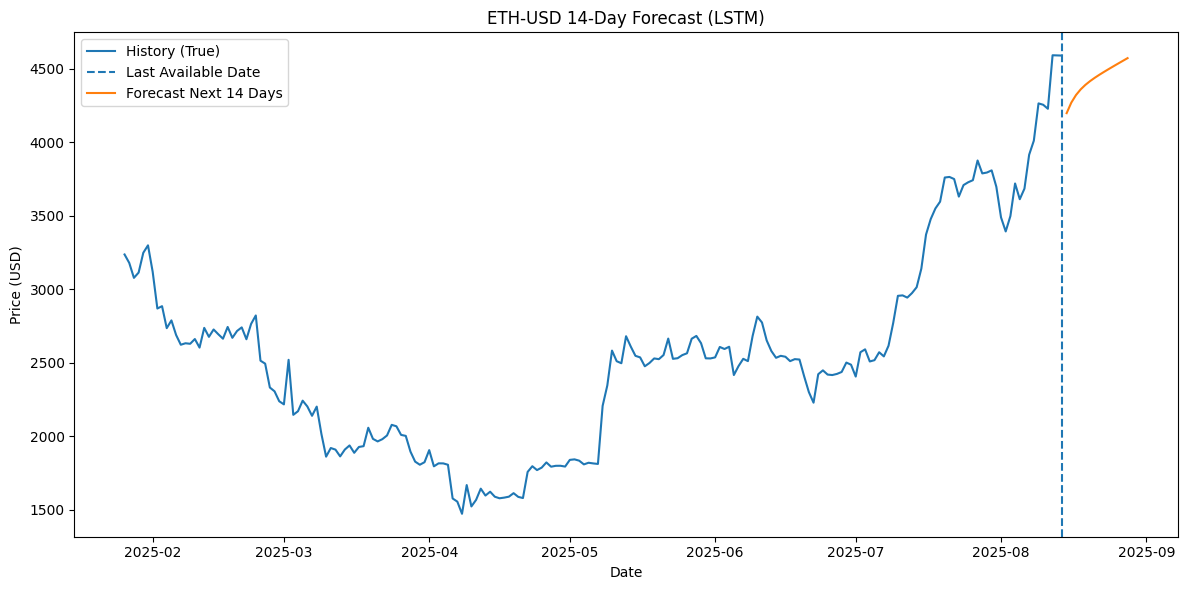

Saved future forecast to: eth_lstm_forecast.csv
Saved test predictions to: eth_lstm_test_predictions.csv


In [3]:
# Ethereum price prediction using LSTM (fixed version)

import os
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta

try:
    import yfinance as yf
except Exception:
    yf = None

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ----------------------------- Config ---------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data source options
USE_YFINANCE = True   # True: download ETH-USD from Yahoo Finance; False: read from LOCAL_CSV_PATH
LOCAL_CSV_PATH = "ethereum_prices.csv"  # If USE_YFINANCE=False, set your local CSV path

# yfinance symbol & date range
TICKER = "ETH-USD"
START_DATE = "2016-01-01"
END_DATE = None  # None = today

# Features: choose univariate (Close) or multivariate (Open, High, Low, Close, Volume)
USE_MULTIVARIATE = False

# Modeling hyperparameters
LOOKBACK = 60      # timesteps per sample
TEST_SIZE = 0.2    # fraction for test split
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
UNITS = 64         # LSTM units
DROPOUT = 0.2
FUTURE_DAYS = 14   # days to forecast beyond last available date

MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# ----------------------------- Utilities ------------------------------

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Flatten MultiIndex columns (if any) and normalize to simple names like 'Open','Close',etc."""
    cols = []
    for c in df.columns:
        if isinstance(c, tuple):
            # If yfinance returns MultiIndex (col, ticker), take the first element
            cols.append(c[0])
        else:
            cols.append(c)
    df = df.copy()
    df.columns = cols
    return df


def load_data():
    if USE_YFINANCE:
        if yf is None:
            raise ImportError("yfinance is not available. Install yfinance or set USE_YFINANCE = False to use a local CSV.")
        df = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d", progress=False)
        if df.empty:
            raise RuntimeError("Downloaded DataFrame is empty. Check the ticker or your internet connection.")
        # Flatten columns if needed
        df = _normalize_columns(df)
        df.index.name = "Date"
        df = df.reset_index()
    else:
        df = pd.read_csv(LOCAL_CSV_PATH, parse_dates=["Date"])  # will raise if Date missing
        df = df.sort_values("Date").reset_index(drop=True)
        df = _normalize_columns(df)

    print("Columns available in the loaded DataFrame:")
    print(df.columns.tolist())

    # Ensure Close exists
    if "Close" not in df.columns:
        raise KeyError("The DataFrame does not contain a 'Close' column. Please check your data source.")

    # Drop rows with missing Close
    df = df.dropna(subset=["Close"]).reset_index(drop=True)
    return df


def select_features(df: pd.DataFrame):
    if USE_MULTIVARIATE:
        required = ["Open", "High", "Low", "Close", "Volume"]
    else:
        required = ["Close"]

    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    data = df[required].copy()
    return data, required


def train_test_split_by_time(values, dates, test_size=0.2):
    n = len(values)
    split_idx = int((1 - test_size) * n)
    return values[:split_idx], values[split_idx:], dates[:split_idx], dates[split_idx:]


def make_sequences(data_arr, lookback):
    X, y = [], []
    for i in range(lookback, len(data_arr)):
        X.append(data_arr[i - lookback: i])
        y.append(data_arr[i, 0])  # predict first feature (Close)
    return np.array(X), np.array(y)


def build_lstm_model(n_features, lookback, units=64, dropout=0.2, lr=1e-3):
    model = models.Sequential([
        layers.Input(shape=(lookback, n_features)),
        layers.LSTM(units, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model


def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))


def evaluate_predictions(y_true, y_pred):
    metrics = {
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None)))) * 100.0,
    }
    return metrics


def plot_predictions(dates_train, train_true, dates_test, test_true, train_pred=None, test_pred=None, title="ETH-USD LSTM"):
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, train_true, label="Train True")
    if train_pred is not None:
        plt.plot(dates_train, train_pred, label="Train Pred")
    plt.plot(dates_test, test_true, label="Test True")
    if test_pred is not None:
        plt.plot(dates_test, test_pred, label="Test Pred")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_forecast(last_date, hist_dates, hist_true, forecast_dates, forecast_values, title="ETH-USD Forecast"):
    plt.figure(figsize=(12, 6))
    plt.plot(hist_dates, hist_true, label="History (True)")
    plt.axvline(x=last_date, linestyle="--", label="Last Available Date")
    plt.plot(forecast_dates, forecast_values, label=f"Forecast Next {len(forecast_values)} Days")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ----------------------------- Main Flow ------------------------------

def main():
    print("Loading data...")
    df_raw = load_data()

    data, cols = select_features(df_raw)

    # Keep the date index for plotting
    dates = pd.to_datetime(df_raw["Date"]).values

    # Scale features 0-1 for stability
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data.values)

    # Time-based split
    scaled_train, scaled_test, dates_train, dates_test = train_test_split_by_time(scaled, dates, TEST_SIZE)

    if len(scaled_train) <= LOOKBACK:
        raise ValueError(f"Not enough training rows ({len(scaled_train)}) for the requested LOOKBACK={LOOKBACK}.")

    # Create training sequences
    X_train, y_train = make_sequences(scaled_train, LOOKBACK)

    # For test sequences, we need LOOKBACK context that overlaps the end of training
    scaled_combined = np.vstack([scaled_train, scaled_test])
    X_all, y_all = make_sequences(scaled_combined, LOOKBACK)

    # the first test sequence corresponds to index (len(scaled_train) - LOOKBACK) in X_all
    start_i = max(0, len(scaled_train) - LOOKBACK)
    X_test = X_all[start_i:]
    y_test = y_all[start_i:]

    # Helper to invert only the Close (first) column using the fitted scaler
    n_features = scaled.shape[1]

    def invert_close(scaled_close_col):
        scaled_close_col = np.asarray(scaled_close_col).reshape(-1)
        dummy = np.zeros((len(scaled_close_col), n_features))
        dummy[:, 0] = scaled_close_col
        inv = scaler.inverse_transform(dummy)[:, 0]
        return inv

    print("Building model...")
    model = build_lstm_model(n_features=n_features, lookback=LOOKBACK, units=UNITS, dropout=DROPOUT, lr=LEARNING_RATE)
    model.summary()

    ckpt_path = os.path.join(MODEL_DIR, "eth_lstm.best.keras")
    cb = [
        callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1)
    ]

    print("Training...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=cb,
        verbose=1,
        shuffle=False
    )

    # Predictions (scaled)
    print("Predicting...")
    train_pred_scaled = model.predict(X_train, verbose=0).reshape(-1)
    test_pred_scaled = model.predict(X_test, verbose=0).reshape(-1)

    # Inverse transform to price
    train_pred = invert_close(train_pred_scaled)
    test_pred = invert_close(test_pred_scaled)

    # Align y_true for train & test with inverse transform
    train_true = invert_close(y_train)
    test_true = invert_close(y_test)

    # Evaluate
    print("\nEvaluation on Test Set:")
    metrics = evaluate_predictions(test_true, test_pred)
    for k, v in metrics.items():
        print(f"{k}: {v:,.4f}")

    # Dates aligned with sequences
    dates_train_seq = pd.to_datetime(dates_train[LOOKBACK:])
    dates_test_seq = pd.to_datetime(dates_test)

    # Plot predictions (use keyword args to avoid ordering mistakes)
    plot_predictions(
        dates_train=dates_train_seq,
        train_true=train_true,
        dates_test=dates_test_seq,
        test_true=test_true,
        train_pred=train_pred,
        test_pred=test_pred,
        title=f"ETH-USD LSTM ({'Multivariate' if USE_MULTIVARIATE else 'Univariate'})"
    )

    # ------------------ Recursive Forecast for FUTURE_DAYS ------------------
    print(f"\nForecasting next {FUTURE_DAYS} days...")
    last_block = scaled_combined[-LOOKBACK:].copy()
    future_scaled = []

    for _ in range(FUTURE_DAYS):
        x_in = last_block.reshape(1, LOOKBACK, n_features)
        next_scaled_close = float(model.predict(x_in, verbose=0)[0, 0])

        # create next row: copy last row and replace Close (col 0) with predicted scaled value
        next_row = last_block[-1].copy()
        next_row[0] = next_scaled_close

        future_scaled.append(next_scaled_close)
        last_block = np.vstack([last_block[1:], next_row])

    future_prices = invert_close(np.array(future_scaled))

    last_date = pd.to_datetime(df_raw["Date"].iloc[-1])
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=FUTURE_DAYS, freq='D')

    # Plot forecast vs history (last 200 days for context)
    hist_tail = min(200, len(df_raw))
    hist_dates = pd.to_datetime(df_raw["Date"].iloc[-hist_tail:])
    hist_true = df_raw["Close"].iloc[-hist_tail:].values

    plot_forecast(
        last_date=last_date,
        hist_dates=hist_dates,
        hist_true=hist_true,
        forecast_dates=future_dates,
        forecast_values=future_prices,
        title=f"ETH-USD {FUTURE_DAYS}-Day Forecast (LSTM)"
    )

    # Save forecast to CSV
    out = pd.DataFrame({"Date": future_dates, "Predicted_Close": future_prices})
    out_path = "eth_lstm_forecast.csv"
    out.to_csv(out_path, index=False)
    print(f"Saved future forecast to: {out_path}")

    # Save full test predictions
    test_pred_df = pd.DataFrame({
        "Date": pd.to_datetime(dates_test_seq),
        "True_Close": test_true,
        "Pred_Close": test_pred
    })
    test_pred_df.to_csv("eth_lstm_test_predictions.csv", index=False)
    print("Saved test predictions to: eth_lstm_test_predictions.csv")

    return metrics


if __name__ == "__main__":
    main()
